In [1]:
!pip install gensim
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 41.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

import requests, zipfile, os
import io

import nltk
# Uncomment if not downloaded
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2024-10-13 03:31:49--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.50, 13.35.7.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: 'cc.en.300.vec.gz.1'

cc.en.300.vec.gz.1  100%[===================>]   1.23G   155MB/s    in 8.6s    

2024-10-13 03:31:58 (147 MB/s) - 'cc.en.300.vec.gz.1' saved [1325960915/1325960915]



# Load Data

In [4]:
# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [5]:
df = pd.DataFrame({
    'Text': newsgroups.data,
    'Category': newsgroups.target
})
df['Category Name'] = df['Category'].apply(lambda x: newsgroups.target_names[x])
df

,Text,Category,Category Name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,sci.med
18842,\nNot in isolated ground recepticles (usually ...,12,sci.electronics
18843,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware
18844,\nWouldn't this require a hyper-sphere. In 3-...,1,comp.graphics


# Preprocessing

In [6]:
# Lowercasing
df['Text'] = df['Text'].str.lower()

# Remove Punctuation and special characters
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Tokenization
df['Tokens'] = df['Text'].apply(word_tokenize)

# Removing Stopwords
stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['Tokens'] = df['Tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# Embedding Model

In [7]:
from gensim.models import KeyedVectors

# Load the FastText model from the downloaded .vec.gz file
fasttext_model = KeyedVectors.load_word2vec_format('cc.en.300.vec.gz')

In [8]:
def get_fasttext_embedding(token, model):
    try:
        return model[token]  # Get the vector for the token
    except KeyError:
        return np.zeros(model.vector_size)  # Return a zero vector if the token is not found

# Function to embed a list of tokens (i.e., a sentence)
def embed_sentence(tokens, model):
    return np.array([get_fasttext_embedding(token, model) for token in tokens])

In [9]:
df['Embeddings'] = df['Tokens'].apply(lambda tokens: embed_sentence(tokens, fasttext_model))
df

,Text,Category,Category Name,Tokens,Embeddings
0,\n\ni am sure some bashers of pens fans are pr...,10,rec.sport.hockey,"[sure, bashers, pen, fan, pretty, confused, la...","[[-0.016499999910593033, -0.0649000033736229, ..."
1,my brother is in the market for a highperforma...,3,comp.sys.ibm.pc.hardware,"[brother, market, highperformance, video, card...","[[0.01209999993443489, 0.010700000450015068, 0..."
2,\n\n\n\n\tfinally you said what you dream abou...,17,talk.politics.mideast,"[finally, said, dream, mediterranean, new, are...","[[0.008100000210106373, 0.02160000056028366, 0..."
3,\nthink\n\nits the scsi card doing the dma tra...,3,comp.sys.ibm.pc.hardware,"[think, scsi, card, dma, transfer, disk, scsi,...","[[-0.0274, 0.0271, 0.0113, 0.0485, -0.1137, -0..."
4,i have an old jasmine drive which i cannot...,4,comp.sys.mac.hardware,"[old, jasmine, drive, use, new, system, unders...","[[-0.03700000047683716, 0.041999999433755875, ..."
...,...,...,...,...,...
18841,dn from nyedacnsvaxuwecedu david nye\ndn a neu...,13,sci.med,"[dn, nyedacnsvaxuwecedu, david, nye, dn, neuro...","[[0.051500000059604645, -0.33180001378059387, ..."
18842,\nnot in isolated ground recepticles usually a...,12,sci.electronics,"[isolated, ground, recepticles, usually, unusu...","[[0.0289, 0.0317, -0.004, 0.0733, -0.0081, 0.0..."
18843,i just installed a dx cpu in a clone motherboa...,3,comp.sys.ibm.pc.hardware,"[installed, dx, cpu, clone, motherboard, tried...","[[-0.0371, 0.024, 0.0265, 0.038, 0.0026, 0.036..."
18844,\nwouldnt this require a hypersphere in space...,1,comp.graphics,"[wouldnt, require, hypersphere, space, point, ...","[[-0.0369, -0.0194, 0.007, 0.1091, -0.1223, -0..."


# Padding

In [10]:
max_sequence_length = 100
embedding_dim = 300
def pad_embeddings(embedding_matrix, max_len=max_sequence_length, emb_dim=embedding_dim):
    # Ensure that the input is a numpy array
    embedding_matrix = np.array(embedding_matrix)
    
    # Handle the case where the input embedding_matrix is empty
    if embedding_matrix.shape[0] == 0:
        # If the embedding matrix is empty, return a matrix of zeros with the appropriate size
        return np.zeros((max_len, emb_dim))
    
    # Check if the embedding_matrix has the correct dimension
    if embedding_matrix.shape[1] != emb_dim:
        raise ValueError(f"Embedding matrix dimension mismatch: expected {emb_dim}, got {embedding_matrix.shape[1]}")
    
    # Pad or truncate embedding matrix to max_len
    if embedding_matrix.shape[0] < max_len:
        # If the sequence is shorter, pad with zero vectors
        padding_length = max_len - embedding_matrix.shape[0]
        padding = np.zeros((padding_length, emb_dim))
        embedding_matrix = np.vstack((embedding_matrix, padding))
    else:
        # If the sequence is longer, truncate it
        embedding_matrix = embedding_matrix[:max_len]
    
    return embedding_matrix

df['padded_embeddings'] = df['Embeddings'].apply(lambda x: pad_embeddings(x))

# Convert the dataframe column to a numpy array for model input
X = np.array(df['padded_embeddings'].tolist())
y = df['Category'] 

# Prepare Dataset

In [11]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the splits
print("Shape of X_train:", X_train.shape)  # Should be (number_of_train_samples, max_length, embedding_dim)
print("Shape of y_train:", y_train.shape)  # Should be (number_of_train_samples, number_of_classes)
print("Shape of X_test:", X_test.shape)    # Should be (number_of_test_samples, max_length, embedding_dim)
print("Shape of y_test:", y_test.shape)    # Should be (number_of_test_samples, number_of_classes)

Shape of X_train: (15076, 100, 300)
Shape of y_train: (15076,)
Shape of X_test: (3770, 100, 300)
Shape of y_test: (3770,)


In [12]:
# Define the LSTM model with additional dense layers
model = Sequential()
model.add(LSTM(128, input_shape=(max_sequence_length, embedding_dim), return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

# Define cosine annealing learning rate schedule
cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=0.0001,
    first_decay_steps=20,
    t_mul=2,
    alpha=0.01
)
# Compile the model using this schedule
optimizer = Adam(learning_rate=cosine_annealing)

# Compile the model using the custom learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=20,             # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the weights of the best epoch if no improvement
)

# Summary of the model
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,644 (900.95 KB)

 Trainable params: 230,644 (900.95 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Assuming you have defined your LSTM model already
print("Is GPU available:", tf.test.is_gpu_available())

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Is GPU available: True
Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.0567 - loss: 2.9945 - val_accuracy: 0.0560 - val_loss: 2.9883
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0712 - loss: 2.9556 - val_accuracy: 0.0809 - val_loss: 2.6878
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0962 - loss: 2.7057 - val_accuracy: 0.0950 - val_loss: 2.5868
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0934 - loss: 2.6518 - val_accuracy: 0.1122 - val_loss: 2.5442
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1101 - loss: 2.5926 - val_accuracy: 0.1141 - val_loss: 2.5226
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1101 - loss: 2.5801 - val_accuracy: 0.1249 - val_loss: 2.5463
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1236 - loss: 2.5535 - val_accuracy: 0.1377 - val_loss: 2.4300
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 

In [14]:
# Extract and store the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

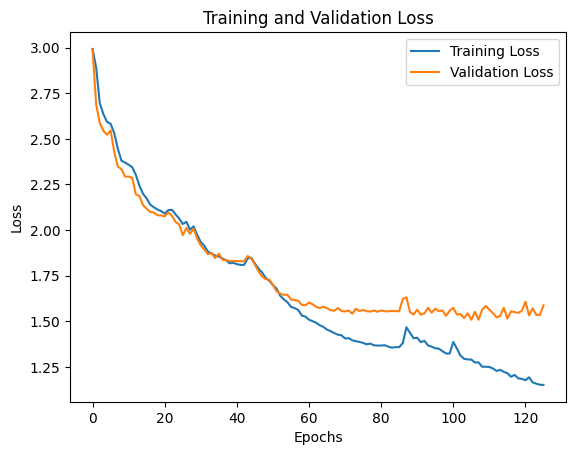

In [15]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

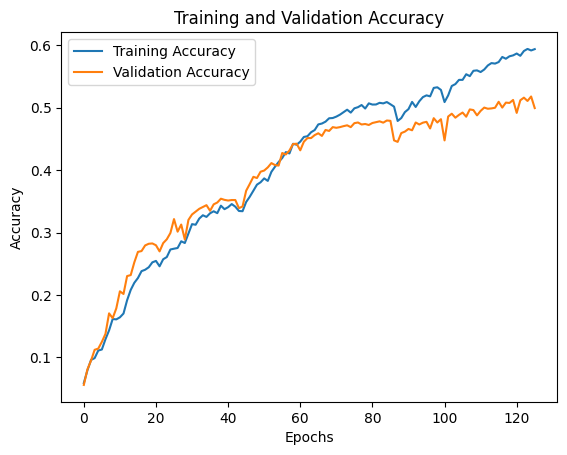

In [16]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4707 - loss: 1.5581
Test Loss: 1.5083725452423096
Test Accuracy: 0.4920424520969391
